In [5]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, confusion_matrix, precision_recall_curve, roc_curve
from src.utils import load_csv, feature_engineer, prepare_xy, split_data, save_artifacts


In [9]:
SAMPLE_FRAC = 0.15
df = load_csv("../data/paysim.csv", sample_frac=SAMPLE_FRAC)
df.shape


(954393, 11)

In [10]:
df = feature_engineer(df)
df.head()


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,orig_balance_diff,dest_balance_diff,abs_amount,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,278,330218.42,20866.00,351084.42,452419.57,122201.15,0,0,-330218.42,330218.42,330218.42,False,False,False,False
1,15,11647.08,30370.00,18722.92,0.00,0.00,0,0,11647.08,0.00,11647.08,False,False,True,False
2,10,152264.21,106589.00,258853.21,201303.01,49038.80,0,0,-152264.21,152264.21,152264.21,False,False,False,False
3,403,1551760.63,0.00,0.00,3198359.45,4750120.08,0,0,0.00,-1551760.63,1551760.63,False,False,False,True
4,206,78172.30,2921331.58,2999503.88,415821.90,337649.60,0,0,-78172.30,78172.30,78172.30,False,False,False,False


In [11]:
df.isnull().sum()


step                 0
amount               0
oldbalanceOrg        0
newbalanceOrig       0
oldbalanceDest       0
newbalanceDest       0
isFraud              0
isFlaggedFraud       0
orig_balance_diff    0
dest_balance_diff    0
abs_amount           0
type_CASH_OUT        0
type_DEBIT           0
type_PAYMENT         0
type_TRANSFER        0
dtype: int64

In [12]:
df['isFraud'].value_counts(), df['isFraud'].value_counts(normalize=True)


(isFraud
 0    953192
 1      1201
 Name: count, dtype: int64,
 isFraud
 0    0.998742
 1    0.001258
 Name: proportion, dtype: float64)

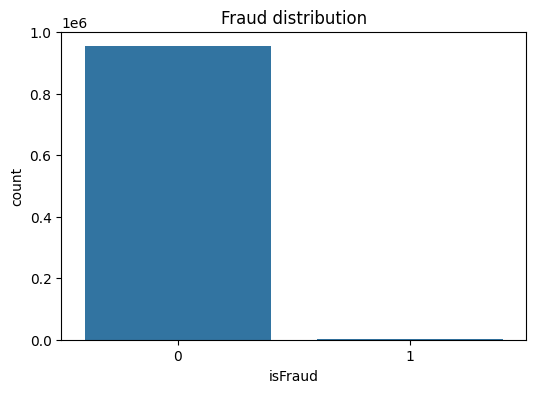

In [13]:
plt.figure(figsize=(6,4))
sns.countplot(x='isFraud', data=df)
plt.title('Fraud distribution')
plt.show()


In [14]:
X, y = prepare_xy(df, target='isFraud')
X_train, X_test, y_train, y_test = split_data(X, y, test_size=0.2)
scaler = StandardScaler()
X_train_num = X_train.select_dtypes(include=[np.number])
X_test_num = X_test.select_dtypes(include=[np.number])
X_train_scaled = scaler.fit_transform(X_train_num)
X_test_scaled = scaler.transform(X_test_num)


In [16]:
from xgboost import XGBClassifier
clf = XGBClassifier(tree_method="hist", n_estimators=500, use_label_encoder=False, eval_metric="logloss", n_jobs=-1)
clf.fit(X_train_scaled, y_train, eval_set=[(X_test_scaled, y_test)], verbose=10)
y_proba = clf.predict_proba(X_test_scaled)[:,1]
print("ROC AUC", roc_auc_score(y_test, y_proba))
print("PR AUC", average_precision_score(y_test, y_proba))
print(classification_report(y_test, clf.predict(X_test_scaled)))


[0]	validation_0-logloss:0.04316


c:\Users\USER\OneDrive\Desktop\paysim_project\paysim_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:35:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[10]	validation_0-logloss:0.00688
[20]	validation_0-logloss:0.00384
[30]	validation_0-logloss:0.00274
[40]	validation_0-logloss:0.00244
[50]	validation_0-logloss:0.00228
[60]	validation_0-logloss:0.00219
[70]	validation_0-logloss:0.00211
[80]	validation_0-logloss:0.00207
[90]	validation_0-logloss:0.00204
[100]	validation_0-logloss:0.00201
[110]	validation_0-logloss:0.00201
[120]	validation_0-logloss:0.00202
[130]	validation_0-logloss:0.00202
[140]	validation_0-logloss:0.00202
[150]	validation_0-logloss:0.00203
[160]	validation_0-logloss:0.00204
[170]	validation_0-logloss:0.00205
[180]	validation_0-logloss:0.00204
[190]	validation_0-logloss:0.00202
[200]	validation_0-logloss:0.00204
[210]	validation_0-logloss:0.00206
[220]	validation_0-logloss:0.00217
[230]	validation_0-logloss:0.00218
[240]	validation_0-logloss:0.00219
[250]	validation_0-logloss:0.00220
[260]	validation_0-logloss:0.00221
[270]	validation_0-logloss:0.00222
[280]	validation_0-logloss:0.00224
[290]	validation_0-logloss:0.

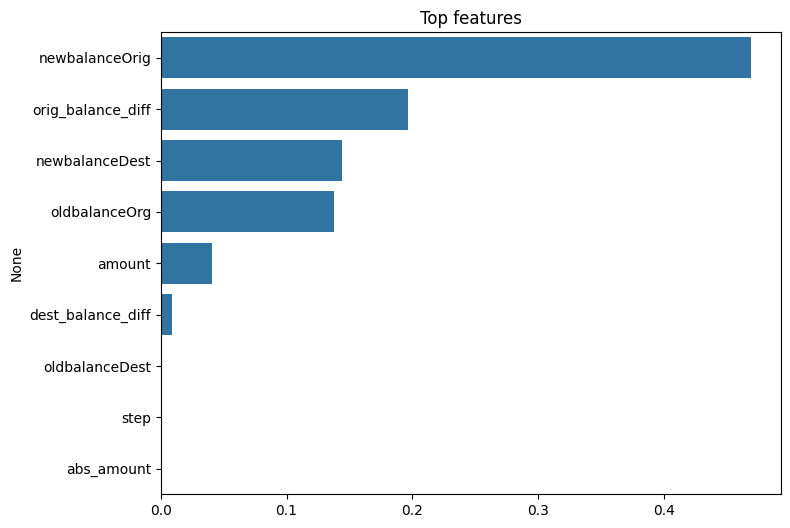

In [17]:
importances = clf.feature_importances_
fi = pd.Series(importances, index=X_train_num.columns).sort_values(ascending=False)[:30]
plt.figure(figsize=(8,6))
sns.barplot(x=fi.values, y=fi.index)
plt.title("Top features")
plt.show()


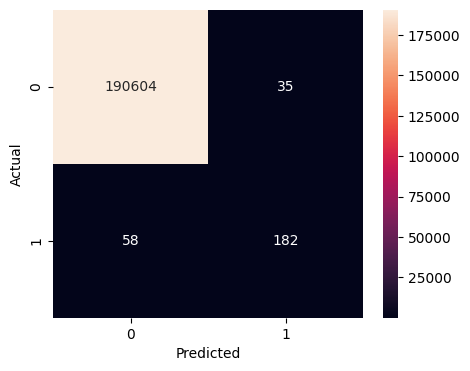

In [18]:
cm = confusion_matrix(y_test, clf.predict(X_test_scaled))
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [19]:
save_artifacts(clf, scaler, X_train_num.columns, out_dir="../artifacts")


In [20]:
sample = X_test_num.sample(10)
probs = clf.predict_proba(scaler.transform(sample))[:,1]
out = sample.copy()
out["fraud_prob"] = probs
out


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,orig_balance_diff,dest_balance_diff,abs_amount,fraud_prob
428859,11,95780.89,185093.61,280874.50,1362049.61,1266268.72,-95780.89,95780.89,95780.89,2.278980e-20
151821,381,518491.67,0.00,0.00,856986.24,1375477.91,0.00,-518491.67,518491.67,1.442454e-27
394743,33,177382.58,10365.00,0.00,123014.84,300397.42,10365.00,-177382.58,177382.58,7.099936e-17
634326,168,179792.40,8287067.88,8466860.28,211105.84,31313.44,-179792.40,179792.40,179792.40,2.179196e-18
434222,687,131846.72,0.00,0.00,2018457.23,2150303.95,0.00,-131846.72,131846.72,1.509583e-17
155160,333,294.91,0.00,0.00,0.00,0.00,0.00,0.00,294.91,4.430964e-06
7088,130,286711.51,0.00,0.00,1021893.89,1359450.07,0.00,-337556.18,286711.51,2.576074e-22
109416,145,1915.80,11462.00,9546.20,0.00,0.00,1915.80,0.00,1915.80,1.575529e-13
878658,312,270659.24,9887206.47,10157865.71,17309130.27,17038471.03,-270659.24,270659.24,270659.24,3.339068e-16
211308,280,172013.49,819.00,0.00,21037.67,193051.17,819.00,-172013.50,172013.49,2.806672e-19
